In [37]:
import sys
import os
import pandas as pd
import joblib
import warnings

In [38]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [39]:
# Aller au dossier racine du projet
project_root = os.path.abspath("..")  # Remonte au dossier principal du projet
src_path = os.path.join(project_root, "src")

# Ajouter le chemin src/ au path Python (évite les doublons)
if src_path not in sys.path:
    sys.path.append(src_path)

# Prédictions
model_path = os.path.abspath(os.path.join("..", "models", "linear_regression.pkl"))
model = joblib.load(model_path)

In [40]:
from data_processing.load_data import load_data
from data_processing.clean_data import clean_data_runs, clean_data_races, clean_before_fitting
from data_processing.merge_data import merge_data
from data_processing.preprocess_data import preprocess_data, split_train_test
from ml_models.linear_regression import train_linear_regression
from metrics.performance_metrics import prepare_predictions, compute_top_prediction, finalize_dataframe, compute_accuracy
from data_processing.output_to_csv import output_to_csv

# Charger les datasets
print("Chargement des données...")
df_runs = load_data("../data/raw/runs.csv")
df_races = load_data("../data/raw/races.csv")

# Nettoyage des données
print("Nettoyage des données...")
clean_data_runs(df_runs)
clean_data_races(df_races)

df = merge_data(df_runs, df_races)
clean_before_fitting(df)

# Prétraitement des données
print("Prétraitement des données...")
df = preprocess_data(df)

# Split en train/test
print("Séparation des données...")
y_train, y_test, X_train, X_test, df_train, df_test = split_train_test(df, train_ratio=0.8)

df_test_original = df_test.copy()

# Entraînement du modèle
print("Entraînement du modèle de régression linéaire...")
train_linear_regression(X_train, y_train)

# Faire des prédictions sur X_test
y_predict = model.predict(X_test)

# Prédiction et évaluation
df = prepare_predictions(df_test_original, y_predict)
df = compute_top_prediction(df)
df_stats = finalize_dataframe(df)

accuracy = compute_accuracy(df_stats)

# Output to csv for analysis
output_to_csv(df_stats, 'statistiques')

print(f"✅ Précision basée sur les courses : {accuracy:.2f}%")

Chargement des données...
Nettoyage des données...
Prétraitement des données...
Séparation des données...
Entraînement du modèle de régression linéaire...
Successfully trained linear_regression model
✅ Précision basée sur les courses : 23.86%


In [41]:
df.head()

,horse_id,won,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,venue_ST,...,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan,y_predict,top_prediction
race_id,,,,,,,,,,,,,,,,,,,,,
5078,976,0.0,3,60,1155.0,133,10,15.0,4.3,1,...,0,0,0,0,0,0,0,0,0.098075,0
5078,1598,0.0,7,79,1116.0,130,8,99.0,46.0,1,...,0,0,1,0,0,0,0,0,0.005217,0
5078,1514,0.0,5,76,1084.0,129,6,25.0,6.3,1,...,0,0,0,0,0,0,0,0,0.090139,0
5078,3673,0.0,6,75,1110.0,123,1,34.0,7.2,1,...,0,0,1,0,0,0,0,0,0.079526,0
5078,627,1.0,4,75,1185.0,128,7,4.4,1.6,1,...,0,0,0,0,0,0,1,0,0.143000,1


In [42]:
df_stats = df_stats.reset_index()
df_stats

,race_id,horse_id,won,y_predict,top_prediction,accuracy
0,5078,976,0,0.098075,0,False
1,5078,1598,0,0.005217,0,False
2,5078,1514,0,0.090139,0,False
3,5078,3673,0,0.079526,0,False
4,5078,627,1,0.143000,1,True
...,...,...,...,...,...,...
15911,6348,1238,0,-0.068453,0,False
15912,6348,985,0,-0.069926,0,False
15913,6348,3147,0,-0.061568,0,False
15914,6348,1982,0,0.122765,0,False


## Winning strategies

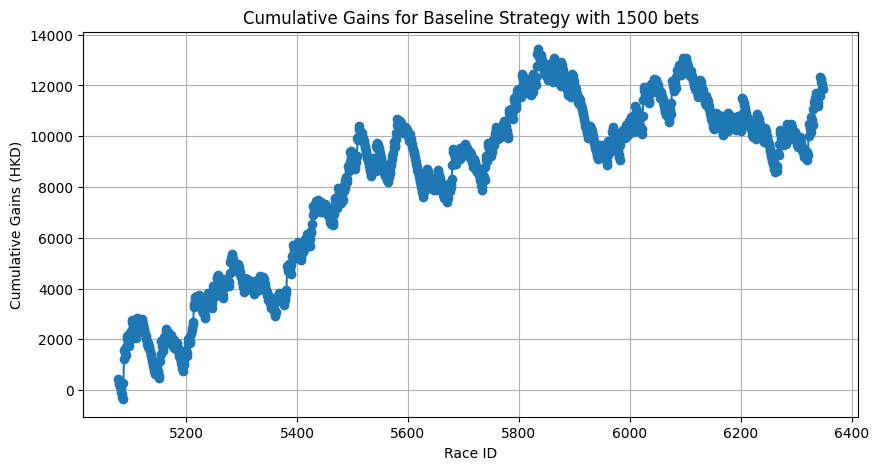

In [43]:
from data_processing.preprocess_data import fetch_winning_dividends
from investment_strategies.baseline_strategy import baseline_strategy
from visualization.plot_results import plot_cumulative_gains 

for i in [1500]:
    df = fetch_winning_dividends(df_stats)
    df = baseline_strategy(df, 100, i)
    plot_cumulative_gains(df, i, "Baseline Strategy")

au hasard

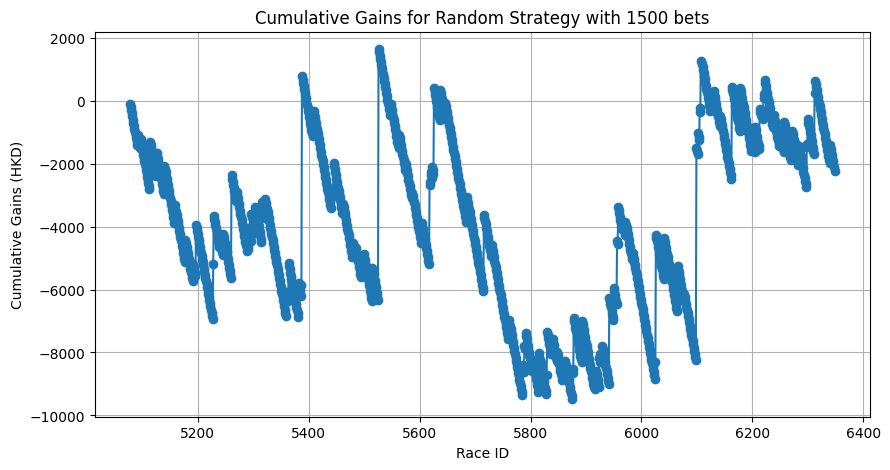

In [44]:
from investment_strategies.random_strategy import random_strategy

for i in [1500]:
    df = fetch_winning_dividends(df_stats)
    df = random_strategy(df, 100, i)

    plot_cumulative_gains(df, i, "Random Strategy")

critère de kelly

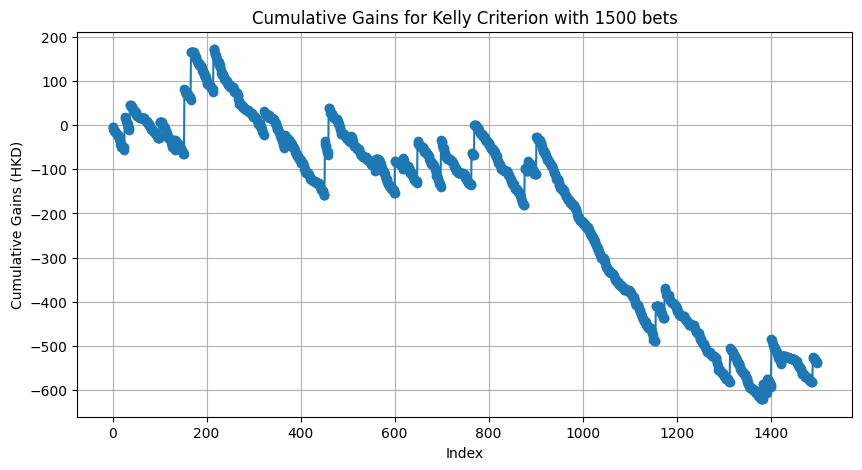

In [45]:
from data_processing.preprocess_data import fetch_winning_dividends_per_prediction
from investment_strategies.Kelly_criterion import kelly_criterion
from visualization.plot_results import plot_cumulative_gains_per_horse

for i in [1500]:
    df = fetch_winning_dividends_per_prediction(df_stats)
    df = kelly_criterion(df, 100, i, 0.01,calibrate_probabilities=False, single_bet_per_race=False)
    plot_cumulative_gains_per_horse(df, i, "Kelly Criterion")

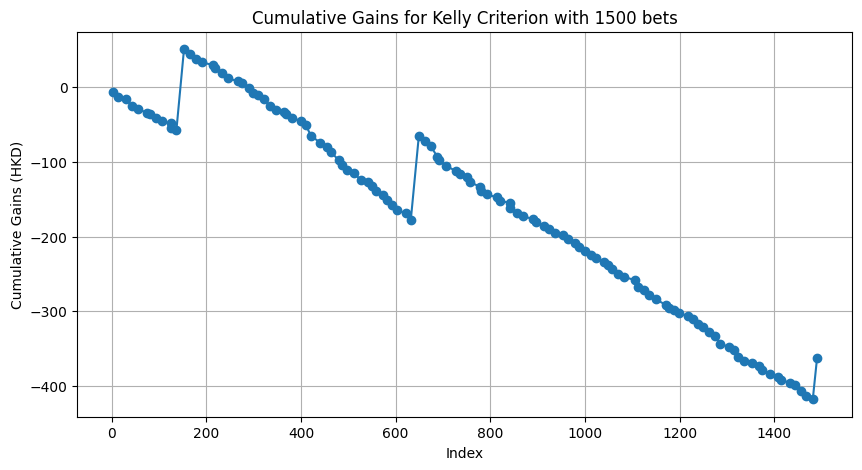

In [46]:
for i in [1500]:
    df = fetch_winning_dividends_per_prediction(df_stats)
    df = kelly_criterion(df, 100, i, 0.01,calibrate_probabilities=True, single_bet_per_race=True)
    plot_cumulative_gains_per_horse(df, i, "Kelly Criterion")

Kelly fonctionne moins bien car Kelly récompense l'utilisateur si la probabilité de victoire de chaque cheval est vraiment pertinente, donc elle nécessite une précision quanti dingue car elle fonde le montant à parier sur cette proba.

critère de thorp & zembia

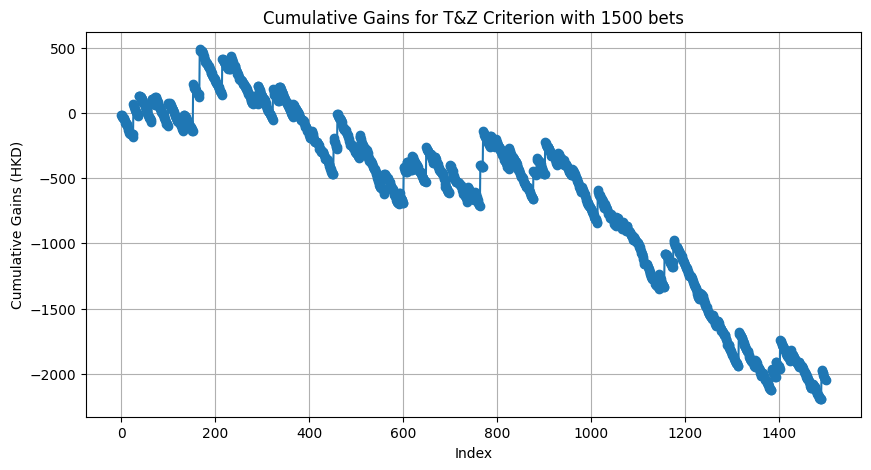

,race_id,horse_id,won,y_predict,win_dividend1,win_odds,num_horses,bet_fraction,bet_amount,gains,cumulative_gains
0,5078,976,0,0.098075,4.40,15.0,14,0.136539,13.653886,-13.653886,-13.653886
1,5078,1598,0,0.005217,4.40,99.0,14,0.000000,0.000000,-0.000000,-13.653886
2,5078,1514,0,0.090139,4.40,25.0,14,0.149319,14.931862,-14.931862,-28.585748
3,5078,3673,0,0.079526,4.40,34.0,14,0.137952,13.795236,-13.795236,-42.380984
4,5078,627,1,0.143000,4.40,4.4,14,0.000000,0.000000,0.000000,-42.380984
...,...,...,...,...,...,...,...,...,...,...,...
1495,5196,459,0,0.113094,13.55,12.0,12,0.152736,15.273643,-15.273643,-2021.924891
1496,5196,4307,0,-0.035868,13.55,99.0,12,0.000000,0.000000,-0.000000,-2021.924891
1497,5196,3525,0,0.114675,13.55,11.0,12,0.147151,14.715091,-14.715091,-2036.639981
1498,5196,4275,0,0.000041,13.55,67.0,12,0.000000,0.000000,-0.000000,-2036.639981


In [47]:
from data_processing.preprocess_data import fetch_winning_dividends_per_prediction
from investment_strategies.thorp_zembia_criterion import thorp_zembia_criterion 
from visualization.plot_results import plot_cumulative_gains_per_horse

for i in [1500]:
    df = fetch_winning_dividends_per_prediction(df_stats)
    df = thorp_zembia_criterion(df, 100, i, min_kelly=0.01)
    plot_cumulative_gains_per_horse(df, i, "T&Z Criterion")
df


Pareil, si mon modèle est pas opti, il y aura trop de différences entre le y_predict et les odds, donc l'optimisation quanti va mal se faire

## Model finetuning

Test d'ajout et de suppression des features

In [48]:
from metrics.performance_metrics import test_features
from metrics.performance_metrics import shap_analysis

test_features(X_train, X_test, y_train, y_test)

NameError: name 'xgb' is not defined